---
title: Analytical STEM CTF ingredients
authors: [Julie Marie Bekkevold, Georgios Varnavides]  
date: 2025-03-31  
---

In [29]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import ctf # import custom plotting / utils
import cmasher as cmr 
import tqdm
import ipywidgets

In [30]:
# parameters
n = 512
q_max = 2 # inverse Angstroms
q_probe = 1 # inverse Angstroms
wavelength = 0.019687 # 300kV
sampling = 1 / q_max / 2 # Angstroms
reciprocal_sampling = 2 * q_max / n # inverse Angstroms

scan_step_size = 1 # pixels
sx = sy = n//scan_step_size
phi0 = 1.0

In [31]:
def white_noise_object_2D(n, phi0):
    """ creates a 2D real-valued array, whose FFT has random phase and constant amplitude """

    evenQ = n%2 == 0
    
    # indices
    pos_ind = np.arange(1,(n if evenQ else n+1)//2)
    neg_ind = np.flip(np.arange(n//2+1,n))

    # random phase
    arr = np.random.randn(n,n)
    
    # top-left // bottom-right
    arr[pos_ind[:,None],pos_ind[None,:]] = -arr[neg_ind[:,None],neg_ind[None,:]]
    # bottom-left // top-right
    arr[pos_ind[:,None],neg_ind[None,:]] = -arr[neg_ind[:,None],pos_ind[None,:]]
    # kx=0
    arr[0,pos_ind] = -arr[0,neg_ind]
    # ky=0
    arr[pos_ind,0] = -arr[neg_ind,0]

    # zero-out components which don't have k-> -k mapping
    if evenQ:
        arr[n//2,:] = 0 # zero highest spatial freq
        arr[:,n//2] = 0 # zero highest spatial freq

    arr[0,0] = 0 # DC component

    # fourier-array
    arr = np.exp(2j*np.pi*arr)*phi0

    # inverse FFT and remove floating point errors
    arr = np.fft.ifft2(arr).real
    
    return arr

# potential
potential = white_noise_object_2D(n,phi0)
complex_obj = np.exp(1j*potential)

In [32]:
# we build probe in Fourier space, using a soft aperture

qx = qy = np.fft.fftfreq(n,sampling)
q2 = qx[:,None]**2 + qy[None,:]**2
q  = np.sqrt(q2)
theta = np.arctan2(qy[None,:],qx[:,None])

x = y = np.arange(0.,n,scan_step_size)
xx, yy = np.meshgrid(x,y,indexing='ij')
positions = np.stack((xx.ravel(),yy.ravel()),axis=-1)
row, col = ctf.return_patch_indices(positions,(n,n),(n,n))

probe_array_fourier_0 = np.sqrt(
    np.clip(
        (q_probe - q)/reciprocal_sampling + 0.5,
        0,
        1,
    ),
)

In [33]:
def autocorrelation(array):
    """ """
    return np.real(
        np.fft.ifft2(
            np.abs(
                np.fft.fft2(
                    array
                )
            )**2
        )
    )

probe_array_fourier_0_normalized = probe_array_fourier_0 / np.sqrt(np.sum(probe_array_fourier_0**2))
aperture_autocorrelation = autocorrelation(probe_array_fourier_0_normalized)

In [34]:
centered_aperture = np.fft.fftshift(probe_array_fourier_0)
padded_aperture = np.pad(centered_aperture,n//4)

def roll_padded_array(shift_px):
    """ """
    return np.roll(
        padded_aperture,
        shift_px,
        (0,1)
    )[n//4:-n//4,n//4:-n//4]

def double_overlap_difference(shift_px):
    """ """
    array_1 = centered_aperture
    array_2 = roll_padded_array(shift_px)
    return array_2 - array_1

def double_overlap_union(shift_px):
    """ """
    array_1 = centered_aperture
    array_2 = roll_padded_array(shift_px)
    return (array_2 + array_1).clip(0,1)

def double_overlap(shift_px,ax):
    """ """
    im = ax.imshow(
        double_overlap_difference(shift_px),
        alpha = double_overlap_union(shift_px),
        cmap='PiYG',
        vmin=-1.5,
        vmax=1.5,  
    )

    return im

In [35]:
def radially_average_ctf(
    corner_centered_ctf,
    sampling=(sampling,sampling)
):
    """ returns the radially-averaged CTF of a corner-centered 2D CTF array. """
    nx, ny = corner_centered_ctf.shape
    sx, sy = sampling
    
    kx = np.fft.fftfreq(nx,sx)
    ky = np.fft.fftfreq(ny,sy)
    k  = np.sqrt(kx[:,None]**2 + ky[None,:]**2).ravel()

    intensity = corner_centered_ctf.ravel()

    bin_size = kx[1]-kx[0]
    k_bins = np.arange(0, k.max() + bin_size, bin_size)

    inds = k / bin_size
    inds_f = np.floor(inds).astype("int")
    d_ind = inds - inds_f

    nf = np.bincount(inds_f, weights=(1 - d_ind), minlength=k_bins.shape[0])
    nc = np.bincount(inds_f + 1, weights=(d_ind), minlength=k_bins.shape[0])
    n = nf + nc

    I_bins0 = np.bincount(
        inds_f, weights=intensity * (1 - d_ind), minlength=k_bins.shape[0]
    )
    I_bins1 = np.bincount(
        inds_f + 1, weights=intensity * (d_ind), minlength=k_bins.shape[0]
    )

    I_bins = (I_bins0 + I_bins1) / n

    # inds = k_bins <= np.abs(kx).max()

    return k_bins, I_bins

q_bins, I_bins = radially_average_ctf(aperture_autocorrelation)

In [36]:
# visualization
with plt.ioff():
    dpi=72
    fig, (ax_0,ax_1,ax_2) = plt.subplots(1,3,figsize=(680/dpi,260/dpi),dpi=dpi)

fontsize = 12 
ax_0.imshow(
    np.fft.fftshift(
        aperture_autocorrelation
    ),
    cmap = cmr.eclipse
)
ax_0.set(xticks=[],yticks=[])
ax_0.set_title("aperture autocorrelation",fontsize=fontsize)
scatter = ax_0.scatter(n//2,n//2,color='red')
ctf.visualize.add_scalebar(
    ax_0,
    n//4,
    reciprocal_sampling,
    r"$q_{\mathrm{probe}}$",
    size_vertical=2.5,
)

im = double_overlap((0,0),ax_1)
ax_1.set_title("double overlap region",fontsize=fontsize)

ax_1.set(
    facecolor='black',
    xticks=[],
    yticks=[]
)

ctf.visualize.add_scalebar(
    ax_1,
    n//4,
    reciprocal_sampling,
    r"$q_{\mathrm{probe}}$",
    size_vertical=2.5,
)

ax_2.plot(q_bins,I_bins,color='cornflowerblue')
ax_2.set_title("radially-averaged autocorrelation",fontsize=fontsize)
ax_2.set(
    xlim=[0,2*np.sqrt(2)],
    ylim=[-0.025,1.025]
)
ax_2.set(
    yticks=[],
    xticks=[0,1,2],
    xlabel=r"spatial frequency, $q/q_{\mathrm{probe}}$",
    aspect=2*np.sqrt(2) / 1.05
)
vline = ax_2.vlines(1,-0.025,1.025,color='black',linestyle='--')
fig.tight_layout()

fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = False
fig.canvas.layout.height = "280px"
# fig.canvas.toolbar_visible = True
# fig.canvas.toolbar_position = 'bottom'
# fig.canvas.layout.height = "305px"
fig.canvas.layout.width = '680px'

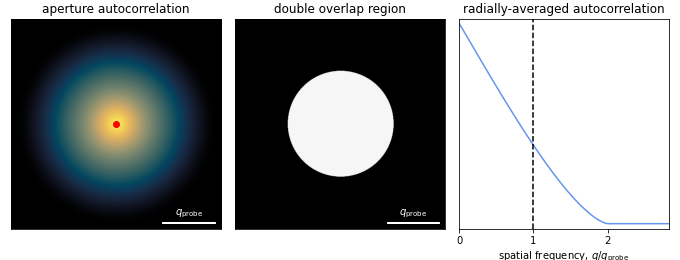

In [37]:
#| label: app:aperture_autocorrelation_widget
def update_plot(shift_px):
    """ """
    scatter.set_offsets([np.flip(shift_px)])
    q = np.linalg.norm((shift_px-n//2)*reciprocal_sampling)
    vline.set_segments([np.array([[q,-0.025],[q,1.025]])])
    im.set_data(double_overlap_difference(shift_px-n//2))
    im.set_alpha(double_overlap_union(shift_px-n//2))
    fig.canvas.draw_idle()
    return None

def onmove(event):
    """ """
    pos = np.array([event.ydata,event.xdata])
    if event.inaxes == ax_0 and pos[0] is not None:
        integer_pos = pos.astype("int")
        update_plot(integer_pos)
        
cid = fig.canvas.mpl_connect('motion_notify_event',onmove)
fig.canvas

In [38]:
def return_chi(
    q,
    theta,
    wavelength,
    C10,
    C12,
    phi12,
    C21,
    phi21,
    C30,
):
    """ """
    prefactor = 2*np.pi / wavelength
    alpha = q*wavelength
    order_2 = alpha**2 / 2 * (C10 + C12*np.cos(2*(theta-phi12)))
    order_3 = alpha**3 / 3 * C21*np.cos(theta-phi21)
    order_4 = alpha**4 / 4 * C30
    
    return (order_2+order_3+order_4) * prefactor

In [52]:
with plt.ioff():
    dpi=72
    fig_chi, axs_chi = plt.subplots(1,2,figsize=(680/dpi,380/dpi),dpi=dpi)

chi = return_chi(
    q,
    theta,
    wavelength,
    100,
    0,
    0,
    0,
    0,
    0
)

sin_chi = np.sin(chi)
chi_q_bins, chi_I_bins = ctf.radially_average_ctf(
    sin_chi,
    (sampling,sampling)
)

im_chi_2D = axs_chi[0].imshow(
    ctf.complex_to_rgb(
        np.fft.fftshift(
            np.exp(-1j*chi)
        )
    )
)

axs_chi[0].set(
    xticks=[],
    yticks=[],
    title="aberration surface"
)

ctf.visualize.add_scalebar(
    axs_chi[0],
    n//4,
    reciprocal_sampling,
    r"$q_{\mathrm{probe}}$",
    color='black',
    size_vertical=2.5,
)

axs_chi[1].axhline(0,color='black',lw=1,linestyle='--')
plot_chi_1D = axs_chi[1].plot(
    chi_q_bins,
    chi_I_bins,
    color='cornflowerblue'
)[0]

axs_chi[1].set(
    xticks=[0,1,2],
    yticks=[],
    xlabel=r"spatial frequency, $q/q_{\mathrm{probe}}$",
    xlim=[0,2],
    ylim=[-1.025,1.025],
    aspect=1/1.025,
    title="radially-averaged aberration surface"
)

fig_chi.tight_layout()
fig_chi.canvas.resizable = False
fig_chi.canvas.header_visible = False
fig_chi.canvas.footer_visible = False
fig_chi.canvas.toolbar_visible = False
fig_chi.canvas.layout.height = "380px"
# fig.canvas.toolbar_visible = True
# fig.canvas.toolbar_position = 'bottom'
# fig.canvas.layout.height = "305px"
fig_chi.canvas.layout.width = '680px'
None

In [66]:
style = {'description_width': 'initial'}
layout_half = ipywidgets.Layout(width="335px",height="30px")
kwargs = {'style':style,'layout':layout_half}

C10_slider = ipywidgets.FloatSlider(
    value = 100,
    min = -500,
    max = 500, 
    step = 1,
    description = r"negative defocus, $C_{1,0}$ [Å]",
    **kwargs
)

C12_slider = ipywidgets.FloatSlider(
    value = 0,
    min = 0,
    max = 100, 
    step = 1,
    description = r"astigmatism, $C_{1,2}$ [Å]",
    **kwargs
)

phi12_slider = ipywidgets.FloatSlider(
    value = 0,
    min = 0,
    max = 90, 
    step = 1,
    description = r"astigmatism angle, $\phi_{1,2}$ [°]",
    **kwargs
)

C21_slider = ipywidgets.FloatSlider(
    value = 0,
    min = 0,
    max = 500, 
    step = 1,
    description = r"coma, $C_{2,1}$ [nm]",
    **kwargs
)

phi21_slider = ipywidgets.FloatSlider(
    value = 0,
    min = 0,
    max = 90, 
    step = 1,
    description = r"coma angle, $\phi_{2,1}$ [°]",
    **kwargs
)

C30_slider = ipywidgets.FloatSlider(
    value = 0,
    min = -100,
    max = 100, 
    step = 0.1,
    description = r"spherical aberration, $C_{3,0}$ [µm]",
    **kwargs
)

reset_button = ipywidgets.Button(
    description="reset aberrations",
    **kwargs
)

scherzer_button = ipywidgets.Button(
    description="use Scherzer defocus",
    **kwargs
)

In [67]:
def update_chi(*args):
    """ """
    C10 = C10_slider.value
    C12 = C12_slider.value
    phi12 = np.deg2rad(phi12_slider.value)
    C21 = C21_slider.value * 10
    phi21 = np.deg2rad(phi21_slider.value)
    C30 = C30_slider.value * 1e4

    chi = return_chi(
        q,
        theta,
        wavelength,
        C10,
        C12,
        phi12,
        C21,
        phi21,
        C30
    )
    
    sin_chi = np.sin(chi)
    chi_q_bins, chi_I_bins = ctf.radially_average_ctf(
        sin_chi,
        (sampling,sampling)
    )

    im_chi_2D.set_data(
        ctf.complex_to_rgb(
            np.fft.fftshift(
                np.exp(-1j*chi)
            )
        )
    )
    plot_chi_1D.set_ydata(chi_I_bins)
    if C12 > 0 or C21 > 0:
        plot_chi_1D.set_alpha(0.5)
        axs_chi[1].set_alpha(0.5)
        axs_chi[1].set_title("radially-averaged* aberration surface",color='gray')
        plot_chi_1D.set_linestyle("--")
    else:
        plot_chi_1D.set_alpha(1)
        axs_chi[1].set_alpha(1)
        axs_chi[1].set_title("radially-averaged aberration surface",color='black')
        plot_chi_1D.set_linestyle("-")
        
    fig_chi.canvas.draw_idle()
    return None

for slider in [C10_slider,C12_slider,phi12_slider,C21_slider,phi21_slider,C30_slider]:
    slider.observe(update_chi,"value")

def reset_aberrations(*args):
    """ """
    C10_slider.value = 100
    C30_slider.value = 0
    C12_slider.value = 0
    phi12_slider.value = 0
    C21_slider.value = 0
    phi21_slider.value = 0
    # update_chi(*args)
    return None

def apply_scherzer(*args):
    """ """
    Cs = C30_slider.value*1e4
    C10_slider.value = -np.sign(Cs) * np.sqrt(3/2*np.abs(Cs)*wavelength)
    # update_chi(*args)
    return None

reset_button.on_click(reset_aberrations)
scherzer_button.on_click(apply_scherzer)

In [68]:
#| label: app:aberration_surface_widget
ipywidgets.VBox(
    [
        ipywidgets.HBox([C10_slider,C30_slider]),
        ipywidgets.HBox([C12_slider,phi12_slider]),
        ipywidgets.HBox([C21_slider,phi21_slider]),
        ipywidgets.HBox([reset_button,scherzer_button]),
        fig_chi.canvas
    ]
)